## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [9]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.3]
redice_lr_patient = [5, 7]

In [10]:

import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 2s 34us/step - loss: 1.2299 - acc: 0.5739 - val_loss: 1.4746 - val_acc: 0.4837
Epoch 14/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.2029 - acc: 0.5838 - val_loss: 1.4563 - val_acc: 0.4881
Epoch 15/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.1784 - acc: 0.5949 - val_loss: 1.4542 - val_acc: 0.4918
Epoch 16/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.1535 - acc: 0.6032 - val_loss: 1.4516 - val_acc: 0.4905
Epoch 17/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.1300 - acc: 0.6127 - val_loss: 1.4565 - val_acc: 0.4965
Epoch 18/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.1078 - acc: 0.6210 - val_loss: 1.4545 - val_acc: 0.4892
Epoch 19/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.0883 - acc: 0.6283 - val_loss: 1.4488 - val_acc: 0.4913
Epoch 20/25
50000/50000 [=====================

50000/50000 [==============================] - 3s 55us/step - loss: 2.2289 - acc: 0.2664 - val_loss: 2.0835 - val_acc: 0.3136
Epoch 2/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.7481 - acc: 0.3891 - val_loss: 1.8389 - val_acc: 0.3659
Epoch 3/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.6257 - acc: 0.4314 - val_loss: 1.6867 - val_acc: 0.4075
Epoch 4/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.5523 - acc: 0.4568 - val_loss: 1.6455 - val_acc: 0.4229
Epoch 5/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.4969 - acc: 0.4751 - val_loss: 1.6067 - val_acc: 0.4343
Epoch 6/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.4506 - acc: 0.4923 - val_loss: 1.5714 - val_acc: 0.4452
Epoch 7/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.4104 - acc: 0.5073 - val_loss: 1.5559 - val_acc: 0.4533
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 2s 38us/step - loss: 0.5184 - acc: 0.8444 - val_loss: 1.5090 - val_acc: 0.5204
Epoch 23/25
50000/50000 [==============================] - 2s 37us/step - loss: 0.5026 - acc: 0.8506 - val_loss: 1.4856 - val_acc: 0.5314
Epoch 24/25
50000/50000 [==============================] - 2s 35us/step - loss: 0.4890 - acc: 0.8563 - val_loss: 1.5246 - val_acc: 0.5201

Epoch 00024: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 25/25
50000/50000 [==============================] - 2s 35us/step - loss: 0.4592 - acc: 0.8704 - val_loss: 1.4939 - val_acc: 0.5324
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               157

50000/50000 [==============================] - 2s 37us/step - loss: 1.2675 - acc: 0.5614 - val_loss: 1.4831 - val_acc: 0.4785
Epoch 9/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.2394 - acc: 0.5735 - val_loss: 1.4735 - val_acc: 0.4833
Epoch 10/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.2132 - acc: 0.5826 - val_loss: 1.4745 - val_acc: 0.4806
Epoch 11/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.1903 - acc: 0.5914 - val_loss: 1.4614 - val_acc: 0.4901
Epoch 12/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.1654 - acc: 0.6012 - val_loss: 1.4511 - val_acc: 0.4885
Epoch 13/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.1459 - acc: 0.6085 - val_loss: 1.4700 - val_acc: 0.4840
Epoch 14/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.1261 - acc: 0.6170 - val_loss: 1.4685 - val_acc: 0.4830
Epoch 15/25
50000/50000 [======================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.8216 - acc: 0.3717 - val_loss: 1.9751 - val_acc: 0.3254
Epoch 2/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.5374 - acc: 0.4558 - val_loss: 2.0814 - val_acc: 0.3264
Epoch 3/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.4373 - acc: 0.4919 - val_loss: 2.2595 - val_acc: 0.3025
Epoch 4/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.3603 - acc: 0.5196 - val_loss: 2.7457 - val_acc: 0.2870
Epoch 5/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.3072 - acc: 0.5393 - val_loss: 2.2093 - val_acc: 0.3158
Epoch 6/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.2543 - acc: 0.5580 - val_loss: 2.1731 - val_acc: 0.3286

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/25
50000/50000 [=======================

50000/50000 [==============================] - 2s 35us/step - loss: 0.7803 - acc: 0.7454 - val_loss: 1.8578 - val_acc: 0.4396
Epoch 23/25
50000/50000 [==============================] - 2s 35us/step - loss: 0.7589 - acc: 0.7519 - val_loss: 1.7182 - val_acc: 0.4501

Epoch 00023: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 24/25
50000/50000 [==============================] - 2s 36us/step - loss: 0.6750 - acc: 0.7923 - val_loss: 1.4915 - val_acc: 0.4943
Epoch 25/25
50000/50000 [==============================] - 2s 35us/step - loss: 0.6545 - acc: 0.7987 - val_loss: 1.4847 - val_acc: 0.5001
Numbers of exp: 10, reduce_factor: 0.30, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               15

50000/50000 [==============================] - 2s 35us/step - loss: 1.5509 - acc: 0.4605 - val_loss: 1.6721 - val_acc: 0.4204
Epoch 9/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.5191 - acc: 0.4718 - val_loss: 1.6526 - val_acc: 0.4303
Epoch 10/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.4906 - acc: 0.4808 - val_loss: 1.6284 - val_acc: 0.4396
Epoch 11/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.4642 - acc: 0.4919 - val_loss: 1.6124 - val_acc: 0.4409
Epoch 12/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.4390 - acc: 0.5003 - val_loss: 1.6020 - val_acc: 0.4446
Epoch 13/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.4172 - acc: 0.5072 - val_loss: 1.5885 - val_acc: 0.4450
Epoch 14/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.3967 - acc: 0.5164 - val_loss: 1.5728 - val_acc: 0.4530
Epoch 15/25
50000/50000 [======================

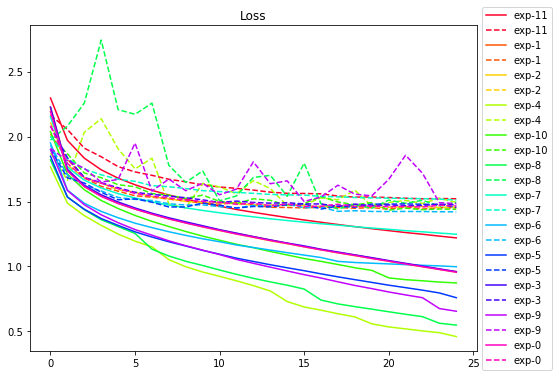

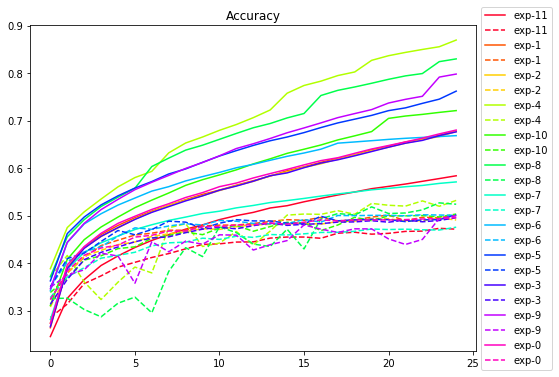

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()